# Detecting Switches  
> This module provides tools to identify potential isoform switches within single-cell isoform-resolution datasets. It includes methods based on Dirichlet distributions and Wilcoxon tests for detecting differential isoform usage. These approaches are still under development and intended for exploratory use, with manual confirmation of detected isoform switches being essential.  


In [1]:
#| hide
from nbdev.showdoc import *

In [2]:
#| default_exp switch_search

In [3]:
#| export
import anndata as ad

In [4]:
#| export
import numpy as np
import pandas as pd
import warnings

from scipy.special import gammaln
from scipy.optimize import minimize
from itertools import combinations
from scipy.stats import chi2
from statsmodels.stats.multitest import multipletests

import scanpy as sc
import anndata as ad

# Parallelization and JIT
from joblib import Parallel, delayed
from numba import njit
from math import lgamma, ceil
import time
import os

warnings.simplefilter(action='ignore', category=FutureWarning)

###############################################################################
# Module-level helper functions for batching and Wilcoxon
###############################################################################
def chunk_list(lst, chunk_size):
    """Yield successive chunks (batches) of chunk_size from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

def compute_batch_size(num_items, n_jobs):
    """Compute a batch size that divides num_items roughly equally among n_jobs workers."""
    return int(ceil(num_items / n_jobs))

def process_gene_batch(filtered_ss, group1, group2, cell_group_column, gene_batch):
    """Process a batch of gene IDs for the Dirichlet test."""
    results = []
    for gene in gene_batch:
        res = filtered_ss.compare_gene(group1, group2, cell_group_column, gene)
        if res is not None:
            results.extend(res)
    return results

def process_pair_wilcoxon(adata_norm, cell_labels_column, group1, group2):
    """Process one pairwise Scanpy Wilcoxon test.
    Operates on a copy of adata_norm.
    """
    adata_pair = adata_norm.copy()
    try:
        sc.tl.rank_genes_groups(
            adata_pair,
            groupby=cell_labels_column,
            groups=[group1],
            reference=group2,
            method='wilcoxon',
            n_genes=adata_pair.shape[0]
        )
        df1 = sc.get.rank_genes_groups_df(adata_pair, group=group1)
        df1['group_1'] = group1
        df1['group_2'] = group2
        df1['contrast'] = f"{group1}__{group2}"

        sc.tl.rank_genes_groups(
            adata_pair,
            groupby=cell_labels_column,
            groups=[group2],
            reference=group1,
            method='wilcoxon',
            n_genes=adata_pair.shape[0]
        )
        df2 = sc.get.rank_genes_groups_df(adata_pair, group=group2)
        df2['group_1'] = group2
        df2['group_2'] = group1
        df2['contrast'] = f"{group1}__{group2}"

        if not df1.empty and not df2.empty:
            return pd.concat([df1, df2], ignore_index=True)
        else:
            return None
    except ValueError:
        return None

###############################################################################
# Helper functions (unchanged)
###############################################################################
def _is_log_transformed(data):
    nonzero = data[data > 0]
    if nonzero.size == 0:
        return False
    fraction_noninteger = np.mean(np.abs(nonzero - np.round(nonzero)) > 1e-3)
    return fraction_noninteger > 0.1

@njit
def _dirichlet_multinomial_nll_numba(alpha, data_np):
    for a in alpha:
        if a <= 0:
            return 1e20
    alpha_sum = 0.0
    for a in alpha:
        alpha_sum += a
    nll = 0.0
    for i in range(data_np.shape[0]):
        row = data_np[i]
        N = 0.0
        for j in range(row.shape[0]):
            N += row[j]
        nll -= lgamma(alpha_sum)
        nll += lgamma(alpha_sum + N)
        for j in range(row.shape[0]):
            nll -= (lgamma(alpha[j] + row[j]) - lgamma(alpha[j]))
    return nll

def _dm_mle(data):
    K = data.shape[1]
    def objective(alpha):
        return _dirichlet_multinomial_nll_numba(alpha, data)
    init_alpha = np.ones(K) + 0.1
    bounds = [(1e-9, None)] * K
    result = minimize(fun=objective, x0=init_alpha, method='L-BFGS-B',
                      bounds=bounds, options={'maxiter': 500, 'ftol': 1e-5})
    if not result.success:
        return float('nan'), np.zeros(K)
    return float(result.fun), result.x

###############################################################################
# The SwitchSearch class: Core isoform switch detection functionality.
###############################################################################
class SwitchSearch(sc.AnnData):
    def __init__(self, anndata: ad.AnnData):
        warnings.simplefilter(action='ignore', category=FutureWarning)
        self.relevant_genes = None
        self._single_fit_cache = {}
        self._combined_fit_cache = {}
        self._init_as_actual(anndata.copy())
        if 'transcriptId' not in self.var_keys():
            self.var['transcriptId'] = self.var.index

    # --- Internal functions for the Dirichlet test ---
    def __fit_single_group(self, group_label, gene_id, cell_group_column='cell_type'):
        cache_key = (group_label, gene_id)
        if cache_key in self._single_fit_cache:
            return self._single_fit_cache[cache_key]

        group_data = self[self.obs[cell_group_column] == group_label]
        if 'geneId' not in group_data.var.columns:
            return (np.nan, None)
        mask_gene = (group_data.var['geneId'] == gene_id)
        data = group_data[:, mask_gene].X.toarray()
        if _is_log_transformed(data):
            raise ValueError("Data appears to be log-transformed. Dirichlet test expects raw counts.")

        total_counts = data.sum(axis=1)
        data = data[total_counts > 9]
        if data.shape[0] == 0:
            self._single_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)

        nll, alpha = _dm_mle(data)
        self._single_fit_cache[cache_key] = (nll, alpha)
        return (nll, alpha)

    def __fit_combined(self, group_label1, group_label2, gene_id, cell_group_column='cell_type'):
        cache_key = (group_label1, group_label2, gene_id)
        if cache_key in self._combined_fit_cache:
            return self._combined_fit_cache[cache_key]

        group1 = self[self.obs[cell_group_column] == group_label1]
        if 'geneId' not in group1.var.columns:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)
        mask1 = (group1.var['geneId'] == gene_id)
        data1 = group1[:, mask1].X.toarray()
        if _is_log_transformed(data1):
            raise ValueError("Data appears to be log-transformed. Dirichlet test expects raw counts.")
        total_counts1 = data1.sum(axis=1)
        data1 = data1[total_counts1 > 9]

        group2 = self[self.obs[cell_group_column] == group_label2]
        if 'geneId' not in group2.var.columns:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)
        mask2 = (group2.var['geneId'] == gene_id)
        data2 = group2[:, mask2].X.toarray()
        if _is_log_transformed(data2):
            raise ValueError("Data appears to be log-transformed. Dirichlet test expects raw counts.")
        total_counts2 = data2.sum(axis=1)
        data2 = data2[total_counts2 > 9]

        if data1.shape[0] == 0 or data2.shape[0] == 0:
            self._combined_fit_cache[cache_key] = (np.nan, None)
            return (np.nan, None)

        combined_data = np.vstack([data1, data2])
        nll, alpha = _dm_mle(combined_data)
        self._combined_fit_cache[cache_key] = (nll, alpha)
        return (nll, alpha)

    def __cached_LRT_test(self, group_label1, group_label2, gene_id, cell_group_column='cell_type'):
        loss1, alpha1 = self.__fit_single_group(group_label1, gene_id, cell_group_column)
        loss2, alpha2 = self.__fit_single_group(group_label2, gene_id, cell_group_column)
        if alpha1 is None or alpha2 is None or np.isnan(loss1) or np.isnan(loss2):
            return None

        loss_full, alpha_full = self.__fit_combined(group_label1, group_label2, gene_id, cell_group_column)
        if alpha_full is None or np.isnan(loss_full):
            return None

        chi2_stat = 2.0 * (loss_full - (loss1 + loss2))
        if chi2_stat < 0:
            return None

        K = len(alpha_full)
        p_value = 1.0 - chi2.cdf(chi2_stat, df=K)
        return chi2_stat, p_value

    def __compare_groups(self, group_1_label, group_2_label, cell_group_column, gene_id):
        test_result = self.__cached_LRT_test(group_1_label, group_2_label, gene_id, cell_group_column)
        if test_result is None:
            return None

        chi2_stat, p_value = test_result
        group1 = self[self.obs[cell_group_column] == group_1_label]
        mask_gene = (group1.var['geneId'] == gene_id)
        data1 = group1[:, mask_gene].X.toarray()
        n_cells_group_1 = group1.shape[0]

        group2 = self[self.obs[cell_group_column] == group_2_label]
        mask_gene2 = (group2.var['geneId'] == gene_id)
        data2 = group2[:, mask_gene2].X.toarray()
        n_cells_group_2 = group2.shape[0]
        total_cells = n_cells_group_1 + n_cells_group_2

        def compute_metrics(counts):
            gene_totals = counts.sum(axis=1, keepdims=True)
            proportions = np.divide(counts, gene_totals, out=np.zeros_like(counts, dtype=float), where=(gene_totals != 0))
            avg_usage = proportions.mean(axis=0)
            pct_expressed = (counts > 0).mean(axis=0) * 100
            return avg_usage, pct_expressed

        avg_usage1, pct_expr1 = compute_metrics(data1)
        avg_usage2, pct_expr2 = compute_metrics(data2)
        log_fc = np.log((avg_usage1 + 1e-6) / (avg_usage2 + 1e-6))
        contrast = f"{group_1_label}__{group_2_label}"

        results = []
        transcript_ids = self.var.loc[self.var['geneId'] == gene_id, 'transcriptId'].values
        for j, tid in enumerate(transcript_ids):
            result_dict = {
                "gene_id": gene_id,
                "transcript_id": tid,
                "group_1": group_1_label,
                "group_2": group_2_label,
                "contrast": contrast,
                "p_value": p_value,
                "chi2_stat": chi2_stat,
                "log_fold_change": log_fc[j],
                "avg_usage_group_1": avg_usage1[j],
                "avg_usage_group_2": avg_usage2[j],
                "n_cells_group_1": n_cells_group_1,
                "n_cells_group_2": n_cells_group_2,
                "total_cells": total_cells,
                "percent_expressed_group_1": pct_expr1[j],
                "percent_expressed_group_2": pct_expr2[j]
            }
            results.append(result_dict)

        return results

    # Public method so that module-level functions can call it.
    def compare_gene(self, group1, group2, cell_group_column, gene):
        return self.__compare_groups(group1, group2, cell_group_column, gene)

    def __filter_genes(self, group_1_label, group_2_label, cell_group_column,
                       min_count=9, min_log_fold_change=0.5, filter_loud=False):
        group_1 = self[self.obs[cell_group_column] == group_1_label]
        group_2 = self[self.obs[cell_group_column] == group_2_label]
        gene_counts_1 = np.array(group_1.X.sum(axis=0)).flatten()
        gene_counts_2 = np.array(group_2.X.sum(axis=0)).flatten()
        total_gene_counts = gene_counts_1 + gene_counts_2
        valid_genes_mask = total_gene_counts > min_count

        if filter_loud:
            n_genes_initial = self.shape[1]
            n_genes_passing_count = np.sum(valid_genes_mask)
            print(f"[filter_genes] Genes passing count threshold: {n_genes_passing_count} / {n_genes_initial}")

        adata_slice = self[:, valid_genes_mask]
        group_1_slice = adata_slice[adata_slice.obs[cell_group_column] == group_1_label]
        group_2_slice = adata_slice[adata_slice.obs[cell_group_column] == group_2_label]
        nz1 = (group_1_slice.X != 0).sum(axis=0) > min_count
        nz2 = (group_2_slice.X != 0).sum(axis=0) > min_count
        final_valid_genes = nz1 & nz2

        if filter_loud:
            print(f"[filter_genes] Genes with sufficient nonzero counts in both groups: {np.sum(final_valid_genes)}")

        filtered_data = adata_slice[:, final_valid_genes]
        unique_gene_ids = np.unique(filtered_data.var['geneId'])
        to_remove = []
        for gene_id in unique_gene_ids:
            sub1 = filtered_data[(filtered_data.obs[cell_group_column] == group_1_label),
                                 (filtered_data.var['geneId'] == gene_id)]
            sub2 = filtered_data[(filtered_data.obs[cell_group_column] == group_2_label),
                                 (filtered_data.var['geneId'] == gene_id)]
            X1 = sub1.X.astype(float).toarray()
            X2 = sub2.X.astype(float).toarray()
            if X1.sum() == 0 or X2.sum() == 0:
                to_remove.append(gene_id)
                continue

            percent_1 = X1 / X1.sum()
            percent_2 = X2 / X2.sum()

            col_sum1 = percent_1.sum(axis=0)
            col_sum2 = percent_2.sum(axis=0)
            log_fold_changes = np.abs(np.log((col_sum1 + 1e-6) / (col_sum2 + 1e-6)))
            lfc_found = np.any(log_fold_changes >= min_log_fold_change)
            if not lfc_found:
                to_remove.append(gene_id)

        filtered_data = filtered_data[:, ~filtered_data.var['geneId'].isin(to_remove)]
        return SwitchSearch(filtered_data)

    def __scanpy_wilcoxon_switching_isoforms(self, cell_labels_column='cell_type',
                                             min_fdr=0.05, min_log_fold_change=0.3,
                                             n_jobs=1):
        adata_norm = self.copy()
        if adata_norm.shape[0] == 0:
            return pd.DataFrame()

        if 'transcriptId' not in adata_norm.var.columns:
            adata_norm.var['transcriptId'] = adata_norm.var_names

        adata_norm.obs[cell_labels_column] = adata_norm.obs[cell_labels_column].astype('category')
        if hasattr(adata_norm.X, "toarray"):
            X_dense = adata_norm.X.toarray()
        else:
            X_dense = adata_norm.X

        if not _is_log_transformed(X_dense):
            lib_sizes = X_dense.sum(axis=1, keepdims=True)
            lib_sizes[lib_sizes == 0] = 1
            X_norm = (X_dense / lib_sizes) * 1e6
            adata_norm.X = np.log1p(X_norm)

        groups = adata_norm.obs[cell_labels_column].cat.categories
        if len(groups) < 2:
            return pd.DataFrame()

        pairs = list(combinations(groups, 2))
        if n_jobs == 1:
            results_list = [process_pair_wilcoxon(adata_norm, cell_labels_column, pair[0], pair[1])
                            for pair in pairs]
        else:
            results_list = Parallel(n_jobs=n_jobs, backend="loky")(
                delayed(process_pair_wilcoxon)(adata_norm, cell_labels_column, pair[0], pair[1])
                for pair in pairs
            )
        results_list = [r for r in results_list if r is not None]
        if not results_list:
            return pd.DataFrame()

        marker_df = pd.concat(results_list, ignore_index=True)
        transcript_to_gene = adata_norm.var.set_index('transcriptId')['geneId'].to_dict()
        marker_df['geneId'] = marker_df['names'].map(transcript_to_gene)

        cell_counts = adata_norm.obs[cell_labels_column].value_counts()
        marker_df['n_cells_group_1'] = marker_df['group_1'].map(cell_counts)
        marker_df['n_cells_group_2'] = marker_df['group_2'].map(cell_counts)
        marker_df['total_cells'] = marker_df['n_cells_group_1'] + marker_df['n_cells_group_2']

        marker_df['adj_pval'] = multipletests(marker_df['pvals_adj'], method='fdr_bh')[1]
        marker_df_filtered = marker_df[
            (marker_df['adj_pval'] <= min_fdr) &
            (marker_df['logfoldchanges'].abs() >= min_log_fold_change)
        ]

        def assign_direction(df):
            return df.assign(
                direction=np.where(
                    df['group_1'] == df['contrast'].str.split("__").str[0],
                    df['logfoldchanges'],
                    -df['logfoldchanges']
                )
            )

        isoswitch_df = (
            marker_df_filtered
            .groupby(['geneId', 'contrast'])
            .apply(assign_direction)
            .reset_index(drop=True)
            .groupby(['geneId', 'contrast'])
            .filter(lambda x: (
                len(x['group_1'].unique()) > 1 and
                len(x['names'].unique()) > 1 and
                x['direction'].abs().sum() != 0
            ))
        )

        def calculate_percent_expression(adata, groupby_column, group, transcript):
            subset = adata[adata.obs[groupby_column] == group, transcript]
            return (subset.X > 0).mean() * 100

        percent_expressions = isoswitch_df.apply(
            lambda row: pd.Series({
                'percent_expressed_group_1': calculate_percent_expression(adata_norm, cell_labels_column, row['group_1'], row['names']),
                'percent_expressed_group_2': calculate_percent_expression(adata_norm, cell_labels_column, row['group_2'], row['names'])
            }),
            axis=1
        )

        isoswitch_df = pd.concat([isoswitch_df, percent_expressions], axis=1)
        isoswitch_df = isoswitch_df.loc[:, ~isoswitch_df.columns.duplicated()]

        isoswitch_df.sort_values(by='adj_pval', inplace=True)
        isoswitch_df = isoswitch_df.rename(columns={
            "geneId": "gene_id",
            "names": "transcript_id",
            "logfoldchanges": "log_fold_change",
            "adj_pval": "p_value"
        })

        cols_order = [
            "gene_id", "transcript_id", "group_1", "group_2", "contrast",
            "p_value", "log_fold_change", "n_cells_group_1", "n_cells_group_2",
            "total_cells", "percent_expressed_group_1", "percent_expressed_group_2"
        ]
        return isoswitch_df

    def find_switching_isoforms_dirichlet(self,
                                          cell_group_column='cell_type',
                                          min_count=30,
                                          min_log_fold_change=0.5,
                                          filter_loud=False,
                                          n_jobs=1,
                                          batch_size=None,
                                          min_fdr=0.05):
        if 'geneId' not in self.var.columns:
            return pd.DataFrame()

        cell_types = self.obs[cell_group_column].unique()
        comparisons = list(combinations(cell_types, 2))
        results = []

        def process_comparison(g1, g2):
            filtered_ss = self.__filter_genes(
                g1, g2,
                cell_group_column=cell_group_column,
                min_count=min_count,
                min_log_fold_change=min_log_fold_change,
                filter_loud=filter_loud
            )
            gene_ids = list(np.unique(filtered_ss.var['geneId']))
            if len(gene_ids) == 0:
                return []
            res_comparison = []
            for gene in gene_ids:
                res = filtered_ss.compare_gene(g1, g2, cell_group_column, gene)
                if res is not None:
                    res_comparison.extend(res)
            return res_comparison

        if n_jobs == 1:
            for g1, g2 in comparisons:
                results.extend(process_comparison(g1, g2))
        else:
            parallel_results = Parallel(n_jobs=n_jobs, backend="loky")(
                delayed(process_comparison)(g1, g2) for g1, g2 in comparisons
            )
            for res in parallel_results:
                if res:
                    results.extend(res)

        results_df = pd.DataFrame(results)
        cols_order = [
            "gene_id", "transcript_id", "group_1", "group_2", "contrast",
            "p_value", "chi2_stat", "log_fold_change", "avg_usage_group_1",
            "avg_usage_group_2", "n_cells_group_1", "n_cells_group_2",
            "total_cells", "percent_expressed_group_1", "percent_expressed_group_2",
            "adj_pval"
        ]
        if not results_df.empty and 'p_value' in results_df.columns:
            results_df['adj_pval'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
            results_df = results_df[results_df['adj_pval'] <= min_fdr]

        results_df = results_df[[col for col in cols_order if col in results_df.columns]]
        self.relevant_genes = results_df
        return results_df

    ###########################################################################
    # UPDATED: Flattened parallel approach for Dirichlet test (nested).
    ###########################################################################
    def find_switching_isoforms_dirichlet_nested(self,
                                                 primary_group_column='cell_type',
                                                 secondary_group_column='condition',
                                                 min_count=30,
                                                 min_log_fold_change=0.5,
                                                 filter_loud=False,
                                                 n_jobs=1,
                                                 batch_size=None,
                                                 min_fdr=0.05):
        """
        Flattened Dirichlet test comparing secondary groups (e.g., case vs. control)
        within each primary group (e.g., cell type). A single Parallel block
        runs over all (primary_group, pair_of_secondary_groups) tasks.
        """
        primary_groups = self.obs[primary_group_column].unique()

        # 1) Gather all tasks (one per (primary, secondary_group1, secondary_group2)).
        tasks = []
        for primary in primary_groups:
            subset = self[self.obs[primary_group_column] == primary]
            if secondary_group_column not in subset.obs.columns:
                continue
            secondary_groups = subset.obs[secondary_group_column].unique()
            if len(secondary_groups) < 2:
                continue
            comparisons = list(combinations(secondary_groups, 2))
            for (g1, g2) in comparisons:
                tasks.append((primary, g1, g2))

        # 2) Define a function to process one task.
        def process_one_task(primary, cond1, cond2):
            # Subset to just this primary group
            subset = self[self.obs[primary_group_column] == primary].copy()
            nested_ss = SwitchSearch(subset)
            # Filter genes for these two conditions
            filtered_ss = nested_ss._SwitchSearch__filter_genes(
                cond1, cond2,
                cell_group_column=secondary_group_column,
                min_count=min_count,
                min_log_fold_change=min_log_fold_change,
                filter_loud=filter_loud
            )
            gene_ids = list(np.unique(filtered_ss.var['geneId']))
            if not gene_ids:
                return []
            local_results = []
            for gene in gene_ids:
                res = filtered_ss.compare_gene(cond1, cond2, secondary_group_column, gene)
                if res is not None:
                    # Annotate each result row with the primary group
                    for entry in res:
                        entry["primary_group"] = primary
                    local_results.extend(res)
            return local_results

        # 3) Run in parallel (flattened).
        if n_jobs == 1:
            results_raw = []
            for t in tasks:
                results_raw.extend(process_one_task(*t))
        else:
            parallel_res = Parallel(n_jobs=n_jobs, backend="loky")(
                delayed(process_one_task)(*t) for t in tasks
            )
            results_raw = [item for sublist in parallel_res for item in sublist]

        results_df = pd.DataFrame(results_raw)
        if results_df.empty:
            return results_df

        # Adjust p-values and filter
        if 'p_value' in results_df.columns:
            results_df['adj_pval'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
            results_df = results_df[results_df['adj_pval'] <= min_fdr]

        cols_order = [
            "primary_group", "gene_id", "transcript_id",
            "group_1", "group_2", "contrast", "p_value", "chi2_stat",
            "log_fold_change", "avg_usage_group_1", "avg_usage_group_2",
            "n_cells_group_1", "n_cells_group_2", "total_cells",
            "percent_expressed_group_1", "percent_expressed_group_2", "adj_pval"
        ]
        return results_df[[c for c in cols_order if c in results_df.columns]]

    def find_switching_isoforms_wilcoxon(self,
                                         cell_group_column='cell_type',
                                         min_fdr=0.05,
                                         min_log_fold_change=0.5,
                                         n_jobs=1):
        return self.__scanpy_wilcoxon_switching_isoforms(
            cell_labels_column=cell_group_column,
            min_fdr=min_fdr,
            min_log_fold_change=min_log_fold_change,
            n_jobs=n_jobs
        )

    ###########################################################################
    # UPDATED: Flattened parallel approach for Wilcoxon test (nested).
    ###########################################################################
    def find_switching_isoforms_wilcoxon_nested(self,
                                                primary_group_column='cell_type',
                                                secondary_group_column='condition',
                                                min_fdr=0.05,
                                                min_log_fold_change=0.5,
                                                n_jobs=1):
        """
        Flattened Wilcoxon test comparing secondary groups (e.g., case vs. control)
        within each primary group (e.g., cell type). A single Parallel block
        runs over all primary groups.
        """
        primary_groups = self.obs[primary_group_column].unique()

        # 1) Gather tasks (one per primary group).
        tasks = []
        for primary in primary_groups:
            tasks.append(primary)

        # 2) Define a function to process one primary group.
        def process_one_task(primary):
            subset = self[self.obs[primary_group_column] == primary].copy()
            if secondary_group_column not in subset.obs.columns:
                return pd.DataFrame()

            nested_ss = SwitchSearch(subset)
            # Reuse the single-level Wilcoxon method on the secondary group column
            nested_res = nested_ss._SwitchSearch__scanpy_wilcoxon_switching_isoforms(
                cell_labels_column=secondary_group_column,
                min_fdr=min_fdr,
                min_log_fold_change=min_log_fold_change,
                n_jobs=1  # ensure single-threaded for this step
            )
            if not nested_res.empty:
                nested_res["primary_group"] = primary
            return nested_res

        # 3) Run in parallel (flattened).
        if n_jobs == 1:
            results = []
            for p in tasks:
                df_res = process_one_task(p)
                if not df_res.empty:
                    results.append(df_res)
        else:
            parallel_res = Parallel(n_jobs=n_jobs, backend="loky")(
                delayed(process_one_task)(p) for p in tasks
            )
            results = [df for df in parallel_res if not df.empty]

        if results:
            return pd.concat(results, ignore_index=True)
        else:
            return pd.DataFrame()


In [5]:
# | export
def create_iso_adata(
    path: str  # Path to a tab-separated file, typically the Sicelore output with transcript counts.
):
    """
    Creates an AnnData object containing isoform counts from a Sicelore output file.

    Parameters:
    - path (str): Path to the input file, which is expected to be tab-separated and contain:
        - `transcriptId`: Transcript identifiers.
        - `geneId`: Gene identifiers.
        - Transcript counts for individual barcodes (cells) as additional columns.

    Returns:
    - adata_iso (AnnData): An AnnData object with isoform counts.
    """

    # Open the input file and read it into a Pandas DataFrame
    with open(path) as isoforms:
        df = pd.read_table(isoforms, sep='\t')

    # Extract the count matrix
    # - `df.iloc[0:, 2:]`: assuming these are counts.
    counts = df.iloc[0:, 2:]

    # Create an AnnData object with the count matrix

    adata_iso = ad.AnnData(counts).transpose()

    # Assign transcript IDs as variable names (columns in the original file)
    adata_iso.var_names = df['transcriptId'].to_list()

    # Add additional variable-level metadata
    # - Include both `transcriptId` and `geneId` as annotations for the variables.
    adata_iso.var = df[['transcriptId', 'geneId']]

    # Create observation-level metadata for barcodes (cells)
    # - Extract column names (barcodes) starting from the 3rd column (index 2).
    barcodes = {'barcodes': df.columns.values[2:]}
    barcodes = pd.DataFrame(data=barcodes)

    # Assign the barcodes DataFrame to the AnnData object as observation metadata
    adata_iso.obs = barcodes

    # Set observation names (row indices) in the AnnData object to match the barcodes
    adata_iso.obs_names = barcodes['barcodes'].tolist()

    # Return the AnnData object containing isoform counts
    return adata_iso

In [6]:
from allos.readers_tests import *
import allos.preprocessing as pp
combined_mouse_data = process_mouse_data()
combined_mouse_data = pp.filter_transcripts_by_abundance(combined_mouse_data,  threshold_pct= 2)





🔎 Looking for file at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File found at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz to /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt...
✅ Decompression complete.
Test data (mouse_1) downloaded successfully
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz to 

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
combined_mouse_data.obs['cell_type'].unique()

array(['mature Glutamatergic', 'Cajal-Retzius', 'imature Glutamatergic',
       'intermediate progenitor', 'radial glia', 'cycling radial glia',
       'imature GABAergic', 'mature GABAergic'], dtype=object)

In [8]:
ss = SwitchSearch(combined_mouse_data)

In [9]:

# Run the Dirichlet–based switch test (will error if data appear log–transformed):
dirichlet_results = ss.find_switching_isoforms_dirichlet(cell_group_column='cell_type',
                                                         min_count=30, min_log_fold_change=1, n_jobs = 10)

# Run the Wilcoxon–based switch test (will CPM–normalize and log–transform if needed):
wilcoxon_results = ss.find_switching_isoforms_wilcoxon(cell_group_column='cell_type',
                                                       min_fdr=0.05, min_log_fold_change=1, n_jobs = 10)


/tmp/ipykernel_847531/2950237862.py:389: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  marker_df_filtered


In [10]:
wilcoxon_results.sort_values(by='log_fold_change')

,transcript_id,scores,log_fold_change,pvals,pvals_adj,group_1,group_2,contrast,gene_id,n_cells_group_1,n_cells_group_2,total_cells,p_value,direction,percent_expressed_group_1,percent_expressed_group_2
1104,ENSMUST00000051477.12,3.983871,1.313683,6.780165e-05,1.978236e-03,cycling radial glia,mature Glutamatergic,cycling radial glia__mature Glutamatergic,Cdc42,117,275,392,1.491337e-02,1.313683,85.470085,72.727273
5019,ENSMUST00000164181.1,4.931299,1.337557,8.168465e-07,4.777785e-05,mature GABAergic,radial glia,mature GABAergic__radial glia,Myl6,172,68,240,5.727071e-04,1.337557,81.395349,75.000000
6031,ENSMUST00000050970.3,3.715006,1.635736,2.031990e-04,5.826363e-03,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Polr1d,275,68,343,3.763291e-02,1.635736,77.454545,61.764706
6032,ENSMUST00000110557.4,3.652179,1.638091,2.600250e-04,7.239154e-03,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Polr1d,68,275,343,4.529321e-02,-1.638091,79.411765,61.818182
1478,ENSMUST00000170241.7,4.264503,1.639061,2.003471e-05,3.617426e-03,imature GABAergic,imature Glutamatergic,imature GABAergic__imature Glutamatergic,Clta,141,234,375,2.520287e-02,1.639061,60.283688,45.299145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,ENSMUST00000107849.9,9.634603,8.724378,5.711261e-22,2.846150e-19,mature GABAergic,radial glia,mature GABAergic__radial glia,Clta,172,68,240,2.694471e-17,8.724378,83.139535,7.352941
1497,ENSMUST00000107849.9,10.725714,8.955872,7.708972e-27,4.268543e-24,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Clta,275,68,343,7.447796e-22,8.955872,87.636364,7.352941
1334,ENSMUST00000066379.10,8.227374,9.537246,1.913624e-16,4.768176e-14,radial glia,imature Glutamatergic,imature Glutamatergic__radial glia,Chchd3,68,234,302,2.459492e-12,-9.537246,66.176471,0.854701
1338,ENSMUST00000066379.10,8.379933,9.760194,5.295773e-17,1.090535e-14,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Chchd3,68,275,343,6.106998e-13,-9.760194,66.176471,0.727273


In [11]:
dirichlet_results

,gene_id,transcript_id,group_1,group_2,contrast,p_value,chi2_stat,log_fold_change,avg_usage_group_1,avg_usage_group_2,n_cells_group_1,n_cells_group_2,total_cells,percent_expressed_group_1,percent_expressed_group_2,adj_pval
3,Clta,ENSMUST00000170241.7,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,1.050406e-07,32.137838,-1.300540,0.147946,0.543153,275,86,361,47.636364,73.255814,5.383331e-07
4,Clta,ENSMUST00000107849.9,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,1.050406e-07,32.137838,0.723716,0.750236,0.363824,275,86,361,87.636364,55.813953,5.383331e-07
7,Pkm,ENSMUST00000163694.3,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,2.930989e-14,62.319359,1.289581,0.786460,0.216579,275,86,361,89.818182,51.162791,3.004264e-13
8,Pkm,ENSMUST00000034834.15,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,2.930989e-14,62.319359,-1.810307,0.126267,0.771793,275,86,361,42.181818,94.186047,3.004264e-13
9,Srsf3,ENSMUST00000130216.1,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,2.658153e-02,7.255078,0.146748,0.881950,0.761573,275,86,361,92.727273,91.860465,4.541011e-02
10,Srsf3,ENSMUST00000037776.14,mature Glutamatergic,intermediate progenitor,mature Glutamatergic__intermediate progenitor,2.658153e-02,7.255078,-1.165232,0.052596,0.168659,275,86,361,21.090909,52.325581,4.541011e-02
11,Myl6,ENSMUST00000218127.1,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,1.018093e-02,9.174478,-1.448639,0.143715,0.611841,275,68,343,37.818182,89.705882,1.897355e-02
12,Myl6,ENSMUST00000164181.1,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,1.018093e-02,9.174478,0.741052,0.783558,0.373453,275,68,343,89.090909,75.000000,1.897355e-02
13,Tecr,ENSMUST00000019382.16,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,7.260738e-07,28.271228,-0.825942,0.339977,0.776519,275,68,343,67.636364,91.176471,2.480752e-06
14,Tecr,ENSMUST00000165740.8,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,7.260738e-07,28.271228,1.259196,0.580023,0.164658,275,68,343,83.636364,45.588235,2.480752e-06


In [12]:
wilcoxon_results.head(20)

,transcript_id,scores,log_fold_change,pvals,pvals_adj,group_1,group_2,contrast,gene_id,n_cells_group_1,n_cells_group_2,total_cells,p_value,direction,percent_expressed_group_1,percent_expressed_group_2
5893,ENSMUST00000034834.15,12.272116,5.359763,1.278680e-34,8.850244e-32,cycling radial glia,mature Glutamatergic,cycling radial glia__mature Glutamatergic,Pkm,117,275,392,5.441936e-29,5.359763,88.888889,42.181818
5894,ENSMUST00000163694.3,11.959407,5.031865,5.797459e-33,3.523300e-30,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,Pkm,275,117,392,1.645196e-27,-5.031865,89.818182,43.589744
5909,ENSMUST00000034834.15,11.985371,5.971428,4.239462e-33,2.112694e-29,intermediate progenitor,mature Glutamatergic,intermediate progenitor__mature Glutamatergic,Pkm,86,275,361,8.865320e-27,5.971428,94.186047,42.181818
1477,ENSMUST00000107849.9,11.686639,5.032757,1.491739e-31,7.908438e-29,mature Glutamatergic,cycling radial glia,cycling radial glia__mature Glutamatergic,Clta,275,117,392,2.994790e-26,-5.032757,87.636364,39.316239
5916,ENSMUST00000034834.15,11.390181,6.393306,4.680185e-30,4.319117e-27,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Pkm,68,275,343,1.156183e-24,-6.393306,95.588235,42.181818
5915,ENSMUST00000163694.3,11.155944,8.153163,6.697808e-29,4.768266e-26,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Pkm,275,68,343,1.039047e-23,8.153163,89.818182,16.176471
1497,ENSMUST00000107849.9,10.725714,8.955872,7.708972e-27,4.268543e-24,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Clta,275,68,343,7.447796e-22,8.955872,87.636364,7.352941
2220,ENSMUST00000154584.8,10.593913,6.469005,3.180146e-26,1.576562e-23,radial glia,mature Glutamatergic,mature Glutamatergic__radial glia,Eef1d,68,275,343,2.569838e-21,-6.469005,89.705882,24.727273
5890,ENSMUST00000163694.3,10.557364,4.570864,4.696683e-26,2.600606e-23,imature Glutamatergic,cycling radial glia,cycling radial glia__imature Glutamatergic,Pkm,234,117,351,4.162578e-21,-4.570864,84.615385,43.589744
1117,ENSMUST00000030417.9,10.449820,7.493307,1.468039e-25,6.773914e-23,mature Glutamatergic,radial glia,mature Glutamatergic__radial glia,Cdc42,275,68,343,1.016153e-20,7.493307,85.090909,14.705882


/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 24917 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


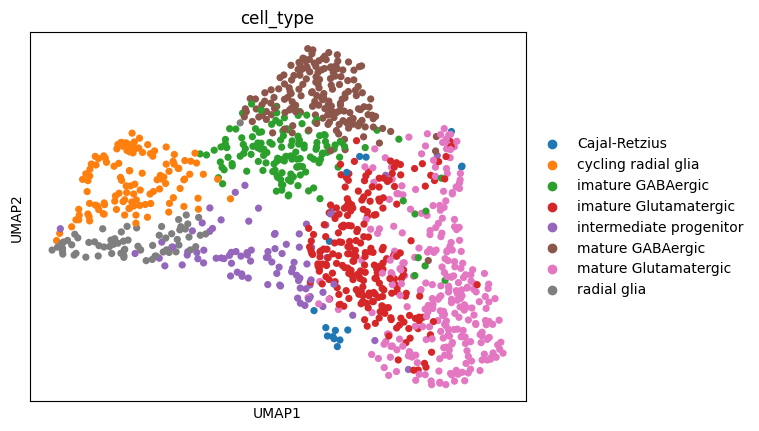

In [13]:
import allos.visuals as vs
sc.pp.normalize_total(combined_mouse_data, target_sum=1e6)
sc.pp.log1p(combined_mouse_data)
sc.pp.neighbors(combined_mouse_data)
sc.tl.umap(combined_mouse_data)
sc.pl.umap(combined_mouse_data, color = 'cell_type')

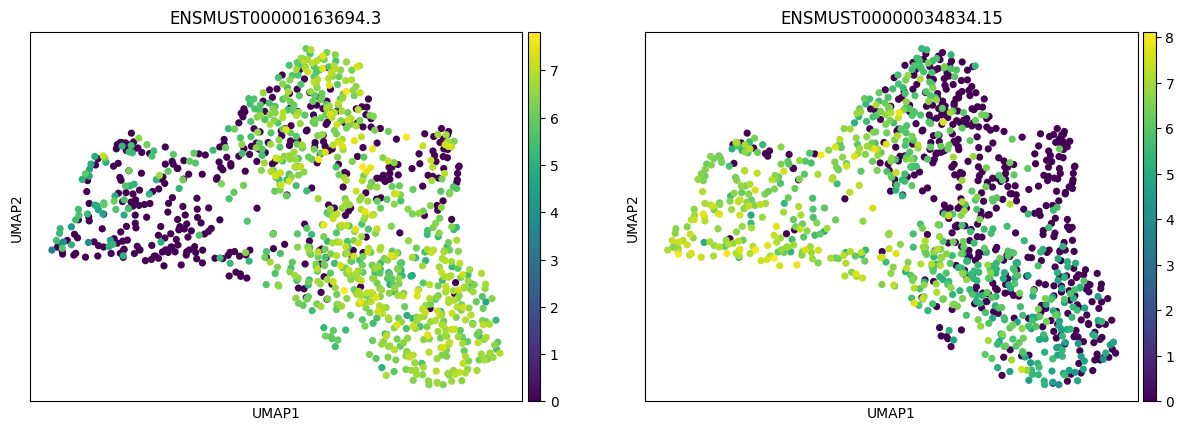

In [14]:
vs.plot_transcripts(combined_mouse_data, gene_id='Pkm')

In [15]:
Pkm_Txs = combined_mouse_data[:, combined_mouse_data.var['geneId'] =='Pkm'].var.index.to_list()

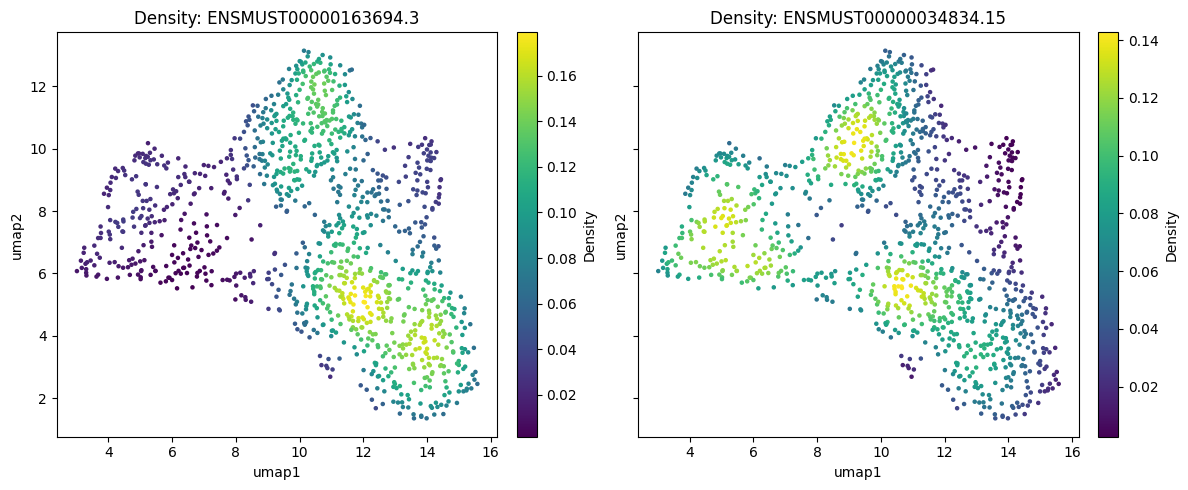

In [16]:
vs.plot_density_multi(combined_mouse_data, features=Pkm_Txs)

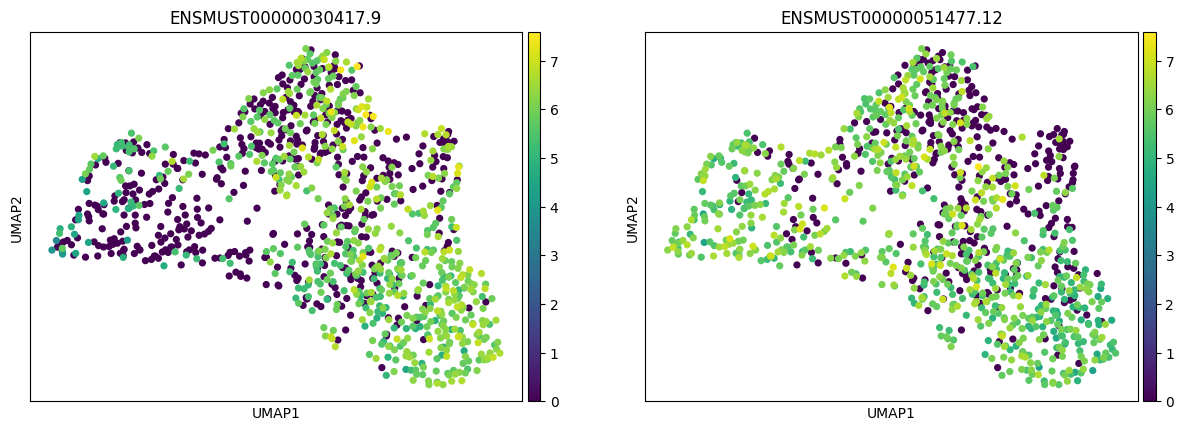

In [17]:
vs.plot_transcripts(combined_mouse_data, gene_id='Cdc42')

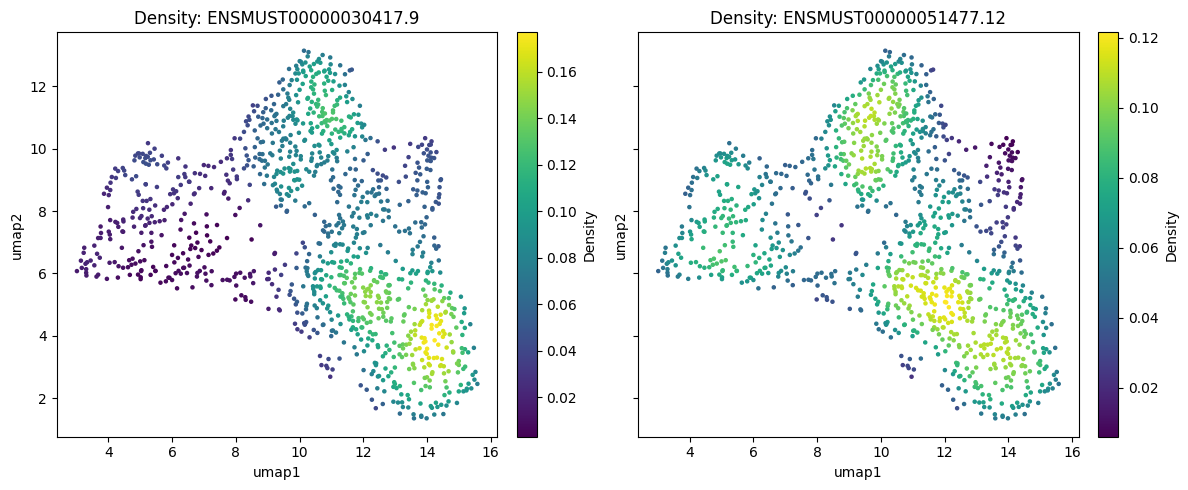

In [18]:
Eef1d_Txs = combined_mouse_data[:, combined_mouse_data.var['geneId'] =='Cdc42'].var.index.to_list()
vs.plot_density_multi(combined_mouse_data, features=Eef1d_Txs)

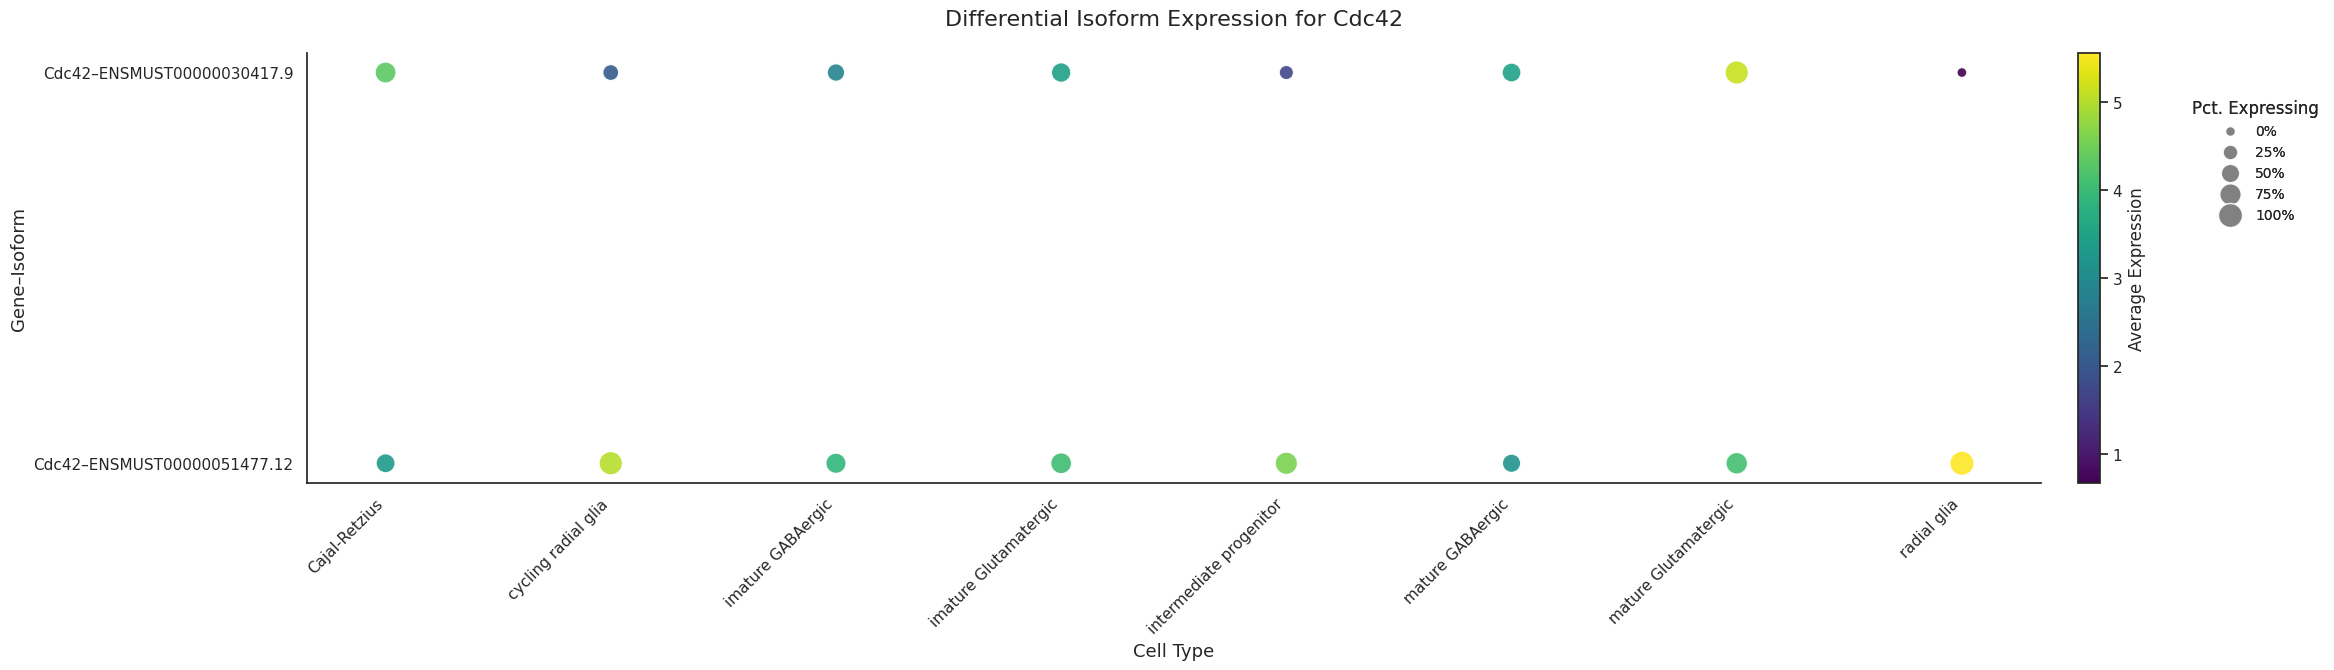

In [19]:
vs.plot_transcript_exspression_dotplot(combined_mouse_data, gene_id= 'Cdc42', top_n=2)

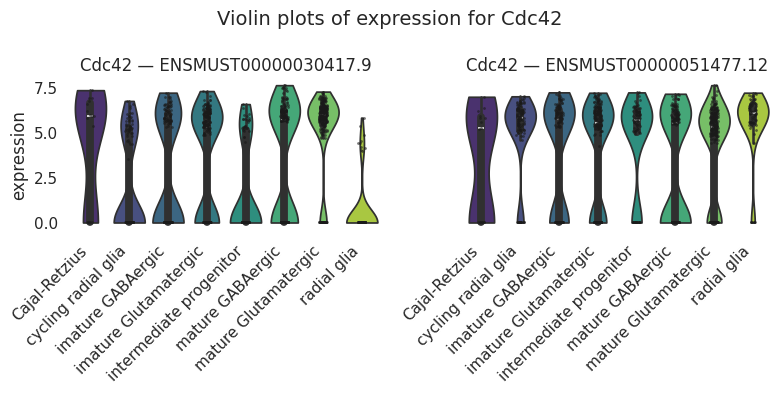

In [20]:
vs.plot_transcript_expression_violin(combined_mouse_data, gene_id= 'Cdc42', top_n=2)

In [21]:
import os
import urllib.request
from pathlib import Path

# Example Ensembl URLs for mouse GRCm39 (release 109)
gtf_url = "ftp://ftp.ensembl.org/pub/release-109/gtf/mus_musculus/Mus_musculus.GRCm39.109.gtf.gz"
fasta_url = "ftp://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz"

# Store data one directory back
data_dir = Path("..") / "data"
data_dir.mkdir(parents=True, exist_ok=True)

gtf_file_local = data_dir / "Mus_musculus.GRCm39.109.gtf.gz"
fasta_file_local = data_dir / "Mus_musculus.GRCm39.dna.primary_assembly.fa.gz"

# Download if not already present
if not gtf_file_local.is_file():
    print(f"Downloading {gtf_url}...")
    urllib.request.urlretrieve(gtf_url, gtf_file_local)

if not fasta_file_local.is_file():
    print(f"Downloading {fasta_url}...")
    urllib.request.urlretrieve(fasta_url, fasta_file_local)




In [23]:
# | export

def get_top_n_isoforms(adata, gene_id, top_n=5, strip=False):
    """
    Get the top_n transcript IDs for a given gene based on overall average expression.

    Parameters:
    - adata: AnnData object containing transcript-level data.
    - gene_id: The gene ID to search for corresponding isoforms.
    - top_n: The number of top isoforms to return based on overall average expression.
    - strip: Boolean indicating whether to strip the dot and everything after from the ID.

    Returns:
    - A list of top_n transcript IDs.
    """
    # Identify isoforms for the given gene ID
    isoforms = adata.var[adata.var['geneId'] == gene_id].index
    if len(isoforms) == 0:
        print(f"No isoforms found for gene ID: {gene_id}")
        return []

    # Calculate the overall average expression for each isoform
    overall_expr = adata.to_df()[isoforms].mean()

    # Get the top_n isoforms by average expression
    top_isoforms = overall_expr.sort_values(ascending=False).head(top_n).index.tolist()

    # Strip the dot and everything after from the ID if strip is True
    if strip:
        top_isoforms = [isoform.split('.')[0] for isoform in top_isoforms]

    return top_isoforms


In [24]:
top_n = get_top_n_isoforms(combined_mouse_data,  gene_id= 'Cdc42', top_n=2, strip = True)

In [25]:
top_n

['ENSMUST00000051477', 'ENSMUST00000030417']

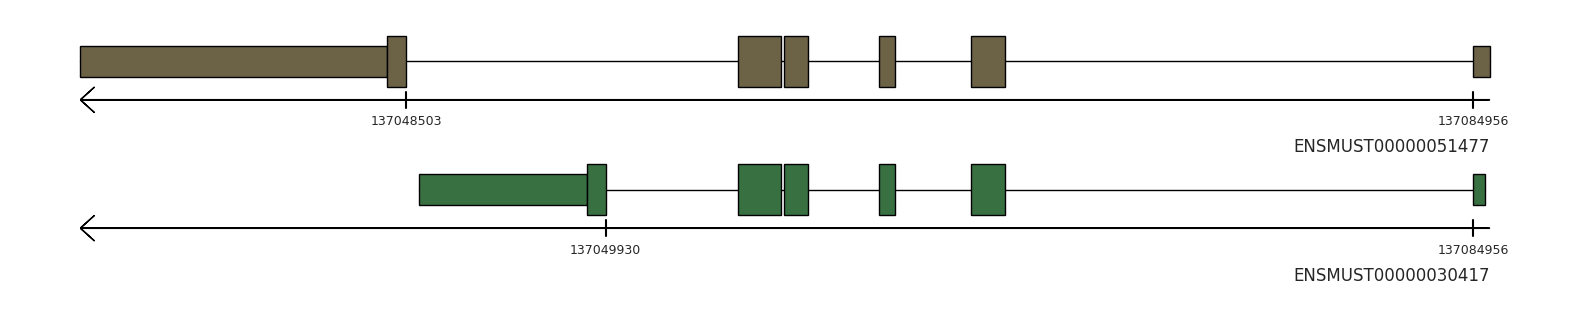

In [26]:
from allos.color_palette import ghibli
from allos.transcript_plots import TranscriptPlots

tp = TranscriptPlots(gtf_file=gtf_file_local)

tp.draw_transcripts_list(['ENSMUST00000051477', 'ENSMUST00000030417'], colors=ghibli,  draw_cds=True)


In [27]:
combined_mouse_data

AnnData object with n_obs × n_vars = 1109 × 24917
    obs: 'batch', 'cell_type'
    var: 'geneId'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [29]:
#| hide
from nbdev.showdoc import *

In [30]:
#| hide
import nbdev; nbdev.nbdev_export()